In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os

In [2]:
kag_info = {}
with open('../kaggle.json') as f:    
    kag_info.update(json.load(f))

os.environ['KAGGLE_USERNAME'] = kag_info['username']
os.environ['KAGGLE_KEY'] = kag_info['key']


In [3]:
!kaggle competitions download -c language-detection

100%|███████████████████████████████████████▉| 376M/377M [00:36<00:00, 11.0MB/s]
100%|████████████████████████████████████████| 377M/377M [00:36<00:00, 10.7MB/s]


In [4]:
!unzip language-detection.zip -d ./

Archive:  language-detection.zip
  inflating: ./test.csv/test.csv     
  inflating: ./train.csv/train.csv   


In [3]:
from sklearn.preprocessing  import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score

In [4]:
SEED = 4

In [46]:
train = pd.read_csv('train.csv/train.csv')
test = pd.read_csv('test.csv/test.csv', index_col=0)

/home/titan/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
train.head(20)

,sentence,language
0,"Pensez à la communication , le discours , les ...",fr
1,"Můžete si ji pronajmout , vzít na splátky , ko...",cs
2,"Každý starosta pochopil , že když mají tyto fo...",cs
3,"Det är ytterligare bevis , men ändå — Jag krit...",sv
4,كان الأمر لا يصدق .,ar
5,"Na primjer , pjesnik ga opisuje ovako .",hr
6,Semua rerumputan itu sekarang menutupi tanah s...,id
7,Det är en enorm utmaning för oss att göra det .,sv
8,Ono što ćete vidjeti - trebat ćete skočiti ovd...,hr
9,( Alqışlar ) Excel-dən istifadə etmişəm .,az


In [7]:
lang_count = (train.language.value_counts().to_frame().reset_index())
lang_count.head(10)

,index,language
0,ru,181970
1,en,157655
2,fr,148585
3,vi,113193
4,ar,110032
5,he,108663
6,ko,105638
7,it,105064
8,ja,104827
9,zh-tw,104011


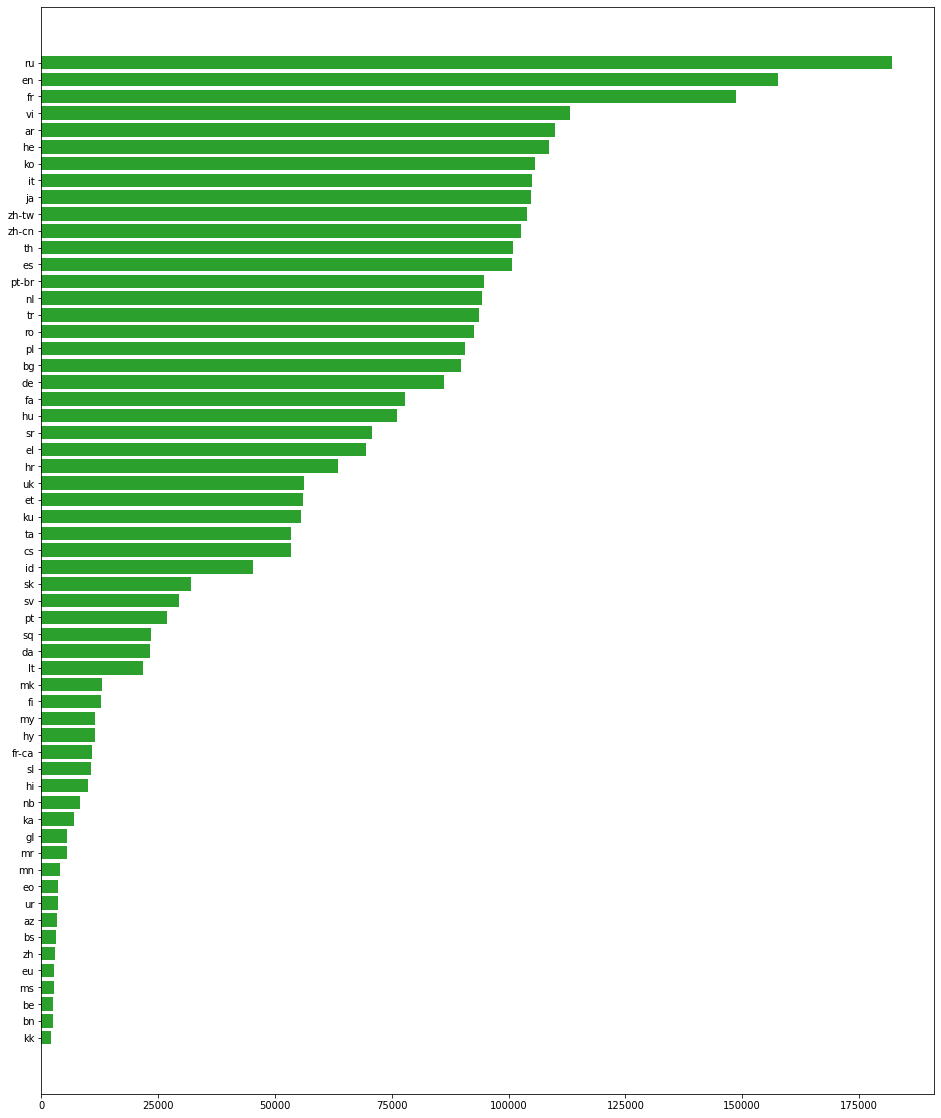

In [8]:
fig, ax = plt.subplots(figsize=(16, 20))

ax.barh(lang_count['index'], lang_count['language'], color='tab:green')
ax.invert_yaxis()

Baseline from lecture

In [12]:
x = train.values[:, 0]
label_encoder = LabelEncoder().fit(train.values[:, 1])
y = label_encoder.transform(train.values[:, 1])

In [13]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('model', SGDClassifier(random_state=SEED, loss='log'))
])

In [14]:
pipe.fit(x, y)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('model', SGDClassifier(loss='log', random_state=4))])

In [15]:
predictions = pipe.predict(x)

In [16]:
balanced_accuracy_score(y, predictions)

0.4712680690687819

In [61]:
submit_predictions = pipe.predict(test.sentence.values)

test['language'] = label_encoder.classes_[submit_predictions]

In [63]:
test = test.reset_index()

In [64]:
test

,index,sentence,language
0,0,תודה לכם,he
1,1,precisamos de compaixão para começar e autoin...,pt-br
2,2,這個增長相當大 並且它將引發經濟的增長,ja
3,3,시애틀에서 자란 제가 처음 가난을 보게 되던 때를 기억해요,ko
4,4,これをロボットに組み込みました,ja
...,...,...,...
2784629,2784629,kako bilo upravo tada se pojavio jedan autor ...,hr
2784630,2784630,y la pequeña victoria que siento cuando lo hag...,es
2784631,2784631,prečo lebo je to v každom z nás,sk
2784632,2784632,ibm과 usda과 같이 하고 있습니다 이를 저작권 보호가 없는 퍼블릭 도메인에 ...,ko


In [67]:
test.head()

(
    test[['index', 'language']]
    .to_csv(f'./sub_1.csv', index=False)
)

!head ./sub_1.csv

index,language
0,he
1,pt-br
2,ja
3,ko
4,ja
5,ja
6,nl
7,nl
8,ru


#### My solutions

In [47]:
def set_equal_form(x):
    return ''.join([symbol.lower() for symbol in x if symbol.isalnum() or symbol == ' '])

Уберем знаки препинания, специальные символы из предложений

In [48]:
%%time

train['sentence'] = train['sentence'].apply(set_equal_form, )
test['sentence'] = test['sentence'].apply(set_equal_form, )

CPU times: user 1min 4s, sys: 339 ms, total: 1min 4s
Wall time: 1min 4s


Нашел, вот такую особенность

In [37]:
train[train.language == 'ru']

,sentence,language
10,после увольнения я решил собрать своих друзей ...,ru
13,ты знаешь что это не гнев заставил моё сердце...,ru
26,гэта што калі мы не яны як але ён каб дзякуй б...,ru
40,ради всех имён которые я никогда не узнаю на...,ru
91,що це тому ми чи дуже які щоб дякую якщо було ...,ru
...,...,...
3159578,гэта што калі мы не яны як але ён каб дзякуй б...,ru
3159582,що це тому ми чи дуже які щоб дякую якщо було ...,ru
3159591,некоторые действительно на грани вымирания,ru
3159619,що це тому ми чи дуже які щоб дякую якщо було ...,ru


In [39]:
train.iloc[train[train.language == 'ru'].sentence.duplicated(keep=False).index]

,sentence,language
10,после увольнения я решил собрать своих друзей ...,ru
13,ты знаешь что это не гнев заставил моё сердце...,ru
26,гэта што калі мы не яны як але ён каб дзякуй б...,ru
40,ради всех имён которые я никогда не узнаю на...,ru
91,що це тому ми чи дуже які щоб дякую якщо було ...,ru
...,...,...
3159578,гэта што калі мы не яны як але ён каб дзякуй б...,ru
3159582,що це тому ми чи дуже які щоб дякую якщо було ...,ru
3159591,некоторые действительно на грани вымирания,ru
3159619,що це тому ми чи дуже які щоб дякую якщо було ...,ru


In [38]:
train.iloc[train[train.language == 'fr'].sentence.duplicated(keep=False).index]

,sentence,language
0,pensez à la communication le discours les ge...,fr
45,le point gps va fondamentalement changer vos v...,fr
63,merci,fr
88,on pourrait penser que les antibiotiques ont p...,fr
107,et il était tellement enthousiasmé quapos il ...,fr
...,...,...
3159490,le monde est empli dapos expressions musicales,fr
3159499,это что мы не как на вы они но из то он так дл...,fr
3159528,sw avec la tête maintenant,fr
3159586,je ne le savais pas au début,fr


То есть помимо дублирования в них есть еще и ошибочные языки, поэтому я очищу данные от дубликатов без сохранения уникального экземпляра

In [49]:
train = train.drop_duplicates(keep=False)

In [50]:
train.shape

(2733631, 2)

In [51]:
x = train.values[:, 0]
label_encoder = LabelEncoder().fit(train.values[:, 1])
y = label_encoder.transform(train.values[:, 1])

In [53]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('model', SGDClassifier(random_state=SEED, loss='log'))
])

In [54]:
pipe.fit(x, y)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('model', SGDClassifier(loss='log', random_state=4))])

In [55]:
predictions = pipe.predict(x)

In [56]:
balanced_accuracy_score(y, predictions)

0.4298933055625565

Странно, вроде убрали не совсем корректные данные, а результат просел

Предположим, что у нас все еще много грязных данных Но их в каждом языке меньше, чем правильных. Тогда можно попробовать выбрать число примеров каждого языка меньшее, чем число экземплятор самого языка. Тогда по идее должно чаще получаться, что будет генерироваться правильная подвыборка. Далее, можно провести несколько таких экспериментов и результат усреднить

 Посмотрим сначала для одного прогона и возьмем число примеров равное числу экземпляров самого маленького языка

In [66]:
df = pd.DataFrame(columns=['sentence', 'language'])

In [58]:
lang_count = (train.language.value_counts().to_frame().reset_index())
n_samples = lang_count['language'].values[-1]

In [59]:
for lang in lang_count['index']:
    tmp = np.random.choice(train[train.language == lang].index, size=n_samples, replace=False)
    df = pd.concat((df, train.loc[tmp]), axis=0)

In [60]:
df

,sentence,language
631937,but i don apost think to any extent that it re...,en
1890556,and then one day it happened he and his fami...,en
1525657,those shapes are difficult to change,en
364666,managing dissent is about recognizing the valu...,en
919844,you said quot quot now everything automatical...,en
...,...,...
442147,сөйтіп бұл құбылыс қос бағытқа да әсер етеді,kk
91610,жарқын өмірге қарсы кедергілерді бұзуға мүмкін...,kk
1555726,міне өткенімнен бірнеше естелік үзінділер,kk
1236181,енді оны сымсыз әрі киілетін етіп ойластыруым...,kk


In [61]:
x = df.values[:, 0]
label_encoder = LabelEncoder().fit(df.values[:, 1])
y = label_encoder.transform(df.values[:, 1])

In [62]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('model', SGDClassifier(random_state=SEED, loss='log'))
])

In [63]:
pipe.fit(x, y)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('model', SGDClassifier(loss='log', random_state=4))])

In [64]:
predictions = pipe.predict(x)

In [65]:
balanced_accuracy_score(y, predictions)

0.9072841505498511

Получилось существенно лучше. Далее проверим идею до конца

In [144]:
from sklearn.model_selection import train_test_split

In [200]:
new_train, new_test = train_test_split(train, test_size=0.15, random_state=SEED)

In [201]:
lang_count_train = (new_train.language.value_counts().to_frame().reset_index())
lang_count_test = (new_test.language.value_counts().to_frame().reset_index())

In [202]:
plt.rcParams['font.size'] = 16

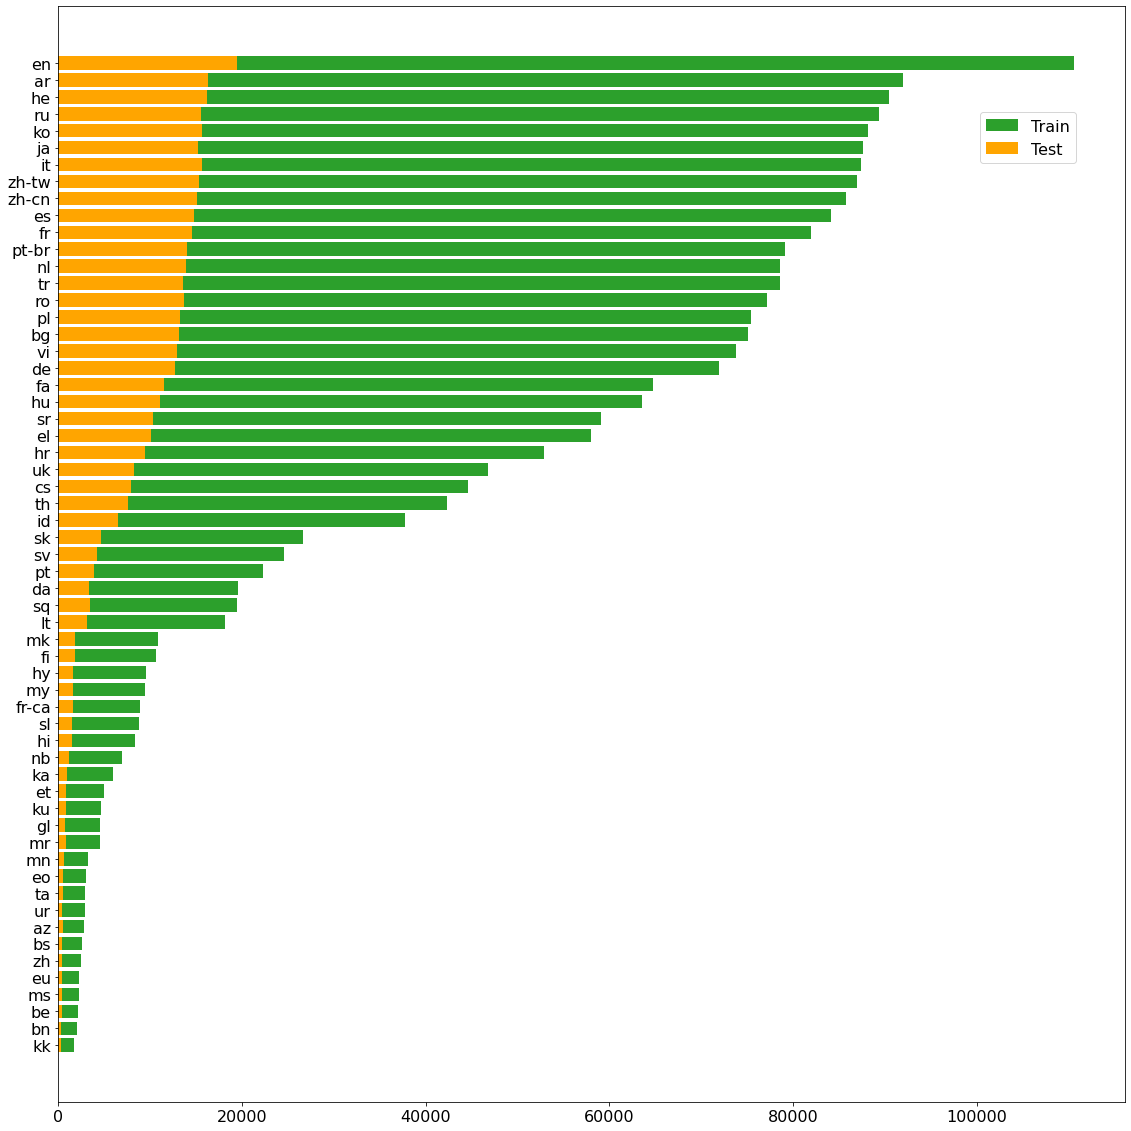

In [203]:
fig, ax = plt.subplots(1, 1, figsize=(16, 16), tight_layout=True)

ax.barh(lang_count_train['index'], lang_count_train['language'], color='tab:green')
ax.barh(lang_count_test['index'], lang_count_test['language'], color='orange')
ax.invert_yaxis()
fig.legend(['Train', 'Test'], bbox_to_anchor=(0.95, 0.9))


In [204]:
import tqdm 
from collections import Counter

In [205]:
n_samples = lang_count_train['language'].values.min()

In [206]:
n_samples

1712

In [207]:
label_encoder = LabelEncoder().fit(new_test.iloc[:, 1])
new_test_target = label_encoder.transform(new_test.language.values)

In [209]:
new_test.shape

(410045, 2)

In [ ]:
N = 5
preds_train = []
preds_test = []
score_train = []
score_test = []
pipes = []
for n in tqdm.tqdm_notebook(range(N)):
    df = pd.DataFrame(columns=['sentence', 'language'])
    n_samples = 1000  
    for lang in lang_count['index']:
        indexes = new_train[new_train.language == lang].index
        tmp = np.random.choice(indexes, size=n_samples, replace=False)
        df = pd.concat((df, new_train.loc[tmp]), axis=0)
        
    x = df.values[:, 0]
    label_encoder = LabelEncoder().fit(df.values[:, 1])
    y = label_encoder.transform(df.values[:, 1])

    pipe = Pipeline([
        ('vectorizer', TfidfVectorizer()),
        ('model', SGDClassifier(random_state=SEED, loss='log'))
    ])
    pipe.fit(x, y)
    preds_train.append(pipe.predict(x))
    predictions = [Counter(np.array(preds_train)[:, i]).most_common(1)[0][0] for i in range(df.shape[0])]
    score_train.append(balanced_accuracy_score(y, np.array(predictions)))
    
    preds_test.append(pipe.predict(new_test.iloc[:, 0]))
    predictions = [Counter(np.array(preds_test)[:, i]).most_common(1)[0][0] for i in range(new_test.shape[0])]
    score_test.append(balanced_accuracy_score(new_test_target, np.array(predictions)))
    
    pipes.append(pipe)


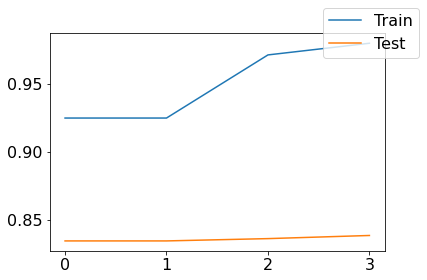

In [218]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(score_train, label='Train')
ax.plot(score_test, label='Test')
fig.legend()

In [219]:
final_preds = [pipe.predict(test.sentence.values) for pipe in pipes]
submit_predictions = [Counter(np.array(final_preds)[:, i]).most_common(1)[0][0] for i in range(test.shape[0])]

KeyboardInterrupt: 

In [221]:
submit_predictions

array([20, 41, 27, ..., 45, 30, 27])

In [222]:
submit_predictions = pipe.predict(test.sentence.values)
test['language'] = label_encoder.classes_[submit_predictions]

In [224]:
(
    test[['index', 'language']]
    .to_csv(f'./sub_4.csv', index=False)
)

!head ./sub_4.csv

index,language
0,he
1,pt
2,ja
3,ko
4,ja
5,ja
6,nl
7,nl
8,ru


In [225]:
os.system(f'kaggle competitions submit -c language-detection -f "sub_4.csv" -m "next_sub"')

0